In [236]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('punkt')
nltk.download('wordnet')
import contractions

from sklearn.feature_extraction.text import TfidfVectorizer
%pip install --upgrade gensim numpy
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint

import warnings
warnings.filterwarnings("ignore")
import os
# all isntead of tenserflow warning
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import logging
logging.getLogger('absl').setLevel(logging.ERROR)

from tqdm import tqdm

[nltk_data] Downloading package punkt to /Users/imosia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/imosia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Defaulting to user installation because normal site-packages is not writeable
  Using cached numpy-2.0.2-cp39-cp39-macosx_14_0_arm64.whl (5.3 MB)
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


# Introduction  

This project is part of Kaggle competition https://www.kaggle.com/c/nlp-getting-started/overview  
The aim of the project is to predict if short corpus of texts collected from tweeter are related to a disaster or not.  
This is bianry classification problem which is related to Natural Language Processing (NLP).  
The test dataset is located on the Kaggle website, the main metric is F1 score.  

# Meeting the data  

**Data description**:  
id - a unique identifier for each tweet  
text - the text of the tweet  
location - the location the tweet was sent from (may be blank)  
keyword - a particular keyword from the tweet (may be blank)  
target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)  

**Files**:  
train.csv - the training set  
test.csv - the test set  
sample_submission.csv - a sample submission file in the correct format   

**Data Size**:  
Train df contains 7613 examples  
Test df contains 3263  

In [237]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

print(train_df.shape)
print(test_df.shape)


(7613, 5)
(3263, 4)


# Exploratory Data Analysis  

In [238]:
display(train_df.head())
print(f"Number of duplicates in train set: {train_df.duplicated().sum()}")
print(f"Number of duplicates in test set: {test_df.duplicated().sum()}")

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Number of duplicates in train set: 0
Number of duplicates in test set: 0


In [239]:
print("Missing values in train set:")
print(train_df.isnull().sum())
print("Missing values in test set:")
print(test_df.isnull().sum())

Missing values in train set:
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64
Missing values in test set:
id             0
keyword       26
location    1105
text           0
dtype: int64


In [240]:
assert train_df['id'].is_unique, "Duplicate IDs found in train set"
assert test_df['id'].is_unique, "Duplicate IDs found in test set"

Distribution of target variable in train set:
target
0    0.57034
1    0.42966
Name: proportion, dtype: float64


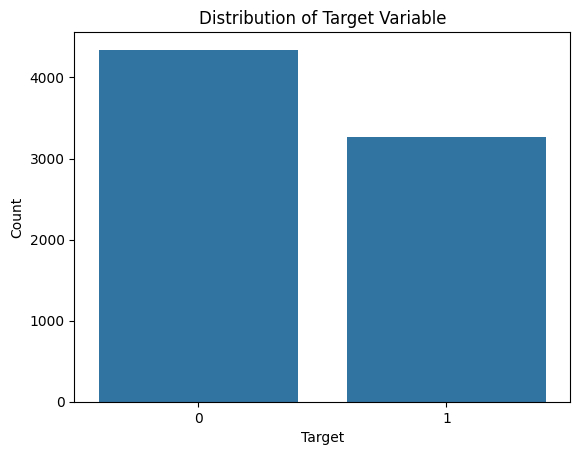

In [241]:
print("Distribution of target variable in train set:")
print(train_df['target'].value_counts(normalize=True))

sns.countplot(x='target', data=train_df)
plt.title('Distribution of Target Variable')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()


In [242]:
print(f"Number of unique locations in train set: {train_df['location'].nunique()}")
print(f"Number of unique locations in test set: {test_df['location'].nunique()}")

print("Top 5 locations in train set by count:")
print(train_df['location'].value_counts().head())

train_df = train_df.drop(columns=['location'])
test_df = test_df.drop(columns=['location'])

Number of unique locations in train set: 3341
Number of unique locations in test set: 1602
Top 5 locations in train set by count:
location
USA              104
New York          71
United States     50
London            45
Canada            29
Name: count, dtype: int64


In [243]:
print(f"Number of unique keywords in train set: {train_df['keyword'].nunique()}")
print(f"Number of unique keywords in test set: {test_df['keyword'].nunique()}")

print("Top 30 keywords in train set by count:")
print(train_df['keyword'].value_counts().head(30))

# Do we really need this information?
train_df['text'] = train_df['text'].astype(str)
test_df['text'] = test_df['text'].astype(str)
train_df['keyword'] = train_df['keyword'].astype(str)
test_df['keyword'] = test_df['keyword'].astype(str)

def keyword_in_text(row):
    return row['keyword'] in row['text']

train_df['keyword_in_text'] = train_df.apply(keyword_in_text, axis=1)
print("Percentage of rows where keyword is in text in train set:")
print(train_df['keyword_in_text'].mean() * 100)
print("Percentage of rows where keyword is in text in test set:")
test_df['keyword_in_text'] = test_df.apply(keyword_in_text, axis=1)
print(test_df['keyword_in_text'].mean() * 100)

print("Examples where keyword is not in text in train set:")
print(train_df[~train_df['keyword_in_text']].sample(5)[['text', 'keyword']])

train_df = train_df.drop(columns=['keyword_in_text', 'keyword'])
test_df = test_df.drop(columns=['keyword_in_text', 'keyword'])

Number of unique keywords in train set: 221
Number of unique keywords in test set: 221
Top 30 keywords in train set by count:
keyword
fatalities     45
deluge         42
armageddon     42
sinking        41
damage         41
harm           41
body%20bags    41
outbreak       40
evacuate       40
fear           40
collided       40
siren          40
twister        40
windstorm      40
sinkhole       39
sunk           39
hellfire       39
weapon         39
weapons        39
famine         39
explosion      39
whirlwind      39
earthquake     39
derailment     39
wreckage       39
collision      39
flames         39
wrecked        39
oil%20spill    38
flooding       38
Name: count, dtype: int64
Percentage of rows where keyword is in text in train set:
52.04255878103245
Percentage of rows where keyword is in text in test set:
52.099295127183574
Examples where keyword is not in text in train set:
                                                   text      keyword
239   ANNIHILATED IN DAMASC

Examples from text column in train set:
['Read an eyewitness account from #Hiroshima from this day in 1945 http://t.co/QUEDV2xxxX #LIFE', "@rjkrraj @KarnakaranK @vimvith whether pressure or not NON wud not survived even if thalapathi didn't release", '[#Latestnews] Police officer wounded suspect dead after exchanging shots: RICHMOND Va. (AP) \x89ÛÓ A Richmond pol... http://t.co/ia1HnGnHVB', '#boy #mix Ultimate #preparedness library: http://t.co/O207JyaByz Prepare Yourself For Any Catastrophe. Over 10 http://t.co/cjCtb2oCxg', '@TOIIndiaNews ofcourse \n\nJust 8 minute b4 tragedy another train had crossed this place \n\nN a flash flood caued washing of tracks..']


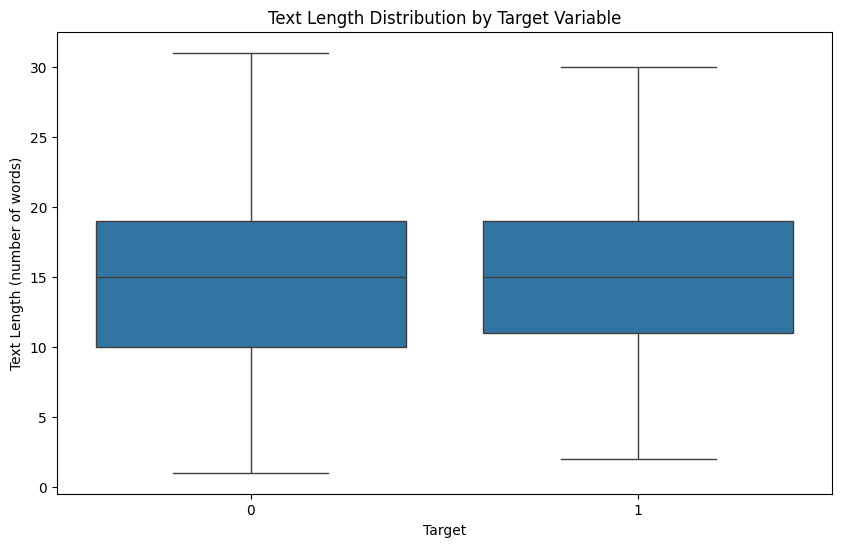

In [244]:
print("Examples from text column in train set:")
print(train_df['text'].sample(5).tolist())

train_df['text_length'] = train_df['text'].apply(lambda x: len(x.split()))
test_df['text_length'] = test_df['text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.boxplot(x='target', y='text_length', data=train_df)
plt.title('Text Length Distribution by Target Variable')
plt.xlabel('Target')
plt.ylabel('Text Length (number of words)')
plt.show()

train_df = train_df.drop(columns=['text_length'])
test_df = test_df.drop(columns=['text_length'])

In [245]:
def clean_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text


def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    words = nltk.word_tokenize(text)
    lemmatized_text = ' '.join([lemmatizer.lemmatize(word) for word in words])
    return lemmatized_text


train_df['cleaned_text'] = train_df['text'].apply(clean_text)
test_df['cleaned_text'] = test_df['text'].apply(clean_text)
train_df['lemmatized_text'] = train_df['cleaned_text'].apply(lemmatize_text)
test_df['lemmatized_text'] = test_df['cleaned_text'].apply(lemmatize_text)

train_df = train_df.drop(columns=['cleaned_text'])
test_df = test_df.drop(columns=['cleaned_text'])


In [246]:
%%time
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
train_tfidf = tfidf_vectorizer.fit_transform(train_df['lemmatized_text'])
test_tfidf = tfidf_vectorizer.transform(test_df['lemmatized_text'])
train_tfidf_df = pd.DataFrame(train_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
test_tfidf_df = pd.DataFrame(test_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())


def train_word2vec_model(texts, vector_size=100, window=5, min_count=1, workers=4):
    tokenized_texts = [nltk.word_tokenize(text) for text in texts]
    model = Word2Vec(sentences=tokenized_texts, vector_size=vector_size, window=window, min_count=min_count, workers=workers)
    return model

train_word2vec_model = train_word2vec_model(train_df['lemmatized_text'])
def vectorize_texts_with_word2vec(model, texts):
    vectors = []
    for text in texts:
        tokens = text.split()
        valid_tokens = [token for token in tokens if token in model.wv]
        if valid_tokens:
            vector = sum(model.wv[token] for token in valid_tokens) / len(valid_tokens)
        else:
            vector = [0] * model.vector_size
        vectors.append(vector)
    return pd.DataFrame(vectors)

train_word2vec_vectors = vectorize_texts_with_word2vec(train_word2vec_model, train_df['lemmatized_text'])
test_word2vec_vectors = vectorize_texts_with_word2vec(train_word2vec_model, test_df['lemmatized_text'])


# additional version of Tf-IDF with very clean text :)

def clean_text_alot(text):
    text = text.lower()
    text = contractions.fix(text)
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#", "", text)
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    tokens = nltk.word_tokenize(text)
    stop_words = set(nltk.corpus.stopwords.words('english'))
    tokens = [t for t in tokens if t not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return " ".join(tokens)

train_df['cleaned_text_alot'] = train_df['text'].apply(clean_text_alot)
test_df['cleaned_text_alot'] = test_df['text'].apply(clean_text_alot)

tfidf_vectorizer_alot = TfidfVectorizer(max_features=1000)
train_tfidf_alot = tfidf_vectorizer_alot.fit_transform(train_df['cleaned_text_alot'])
test_tfidf_alot = tfidf_vectorizer_alot.transform(test_df['cleaned_text_alot'])
train_tfidf_alot_df = pd.DataFrame(train_tfidf_alot.toarray(), columns=tfidf_vectorizer_alot.get_feature_names_out())
test_tfidf_alot_df = pd.DataFrame(test_tfidf_alot.toarray(), columns=tfidf_vectorizer_alot.get_feature_names_out())

# same with 500 features
tfidf_vectorizer_alot = TfidfVectorizer(max_features=500)
train_tfidf_alot_500 = tfidf_vectorizer_alot.fit_transform(train_df['cleaned_text_alot'])
test_tfidf_alot_500 = tfidf_vectorizer_alot.transform(test_df['cleaned_text_alot'])
train_tfidf_alot_500_df = pd.DataFrame(train_tfidf_alot_500.toarray(), columns=tfidf_vectorizer_alot.get_feature_names_out())
test_tfidf_alot_500_df = pd.DataFrame(test_tfidf_alot_500.toarray(), columns=tfidf_vectorizer_alot.get_feature_names_out())

# same with 2500 features
tfidf_vectorizer_alot = TfidfVectorizer(max_features=2500)
train_tfidf_alot_2500 = tfidf_vectorizer_alot.fit_transform(train_df['cleaned_text_alot'])
test_tfidf_alot_2500 = tfidf_vectorizer_alot.transform(test_df['cleaned_text_alot'])
train_tfidf_alot_2500_df = pd.DataFrame(train_tfidf_alot_2500.toarray(), columns=tfidf_vectorizer_alot.get_feature_names_out())
test_tfidf_alot_2500_df = pd.DataFrame(test_tfidf_alot_2500.toarray(), columns=tfidf_vectorizer_alot.get_feature_names_out())

# and with 5k features
tfidf_vectorizer_alot = TfidfVectorizer(max_features=5000)
train_tfidf_alot_5000 = tfidf_vectorizer_alot.fit_transform(train_df['cleaned_text_alot'])
test_tfidf_alot_5000 = tfidf_vectorizer_alot.transform(test_df['cleaned_text_alot'])
train_tfidf_alot_5000_df = pd.DataFrame(train_tfidf_alot_5000.toarray(), columns=tfidf_vectorizer_alot.get_feature_names_out())
test_tfidf_alot_5000_df = pd.DataFrame(test_tfidf_alot_5000.toarray(), columns=tfidf_vectorizer_alot.get_feature_names_out())

CPU times: user 3.01 s, sys: 263 ms, total: 3.28 s
Wall time: 2.98 s


### Conclusion on EDA  
The initial data consist of id, keyword, location, text and label.  

**ID** is unique column in both test and train.  

**Location** has a lot of missing values and wide range of possible values - ommited.  

**Keyword** has a few missing values and may be interesting feature to see on which keywords the future models make mistake.  
However, it was decided to proceed only with test analysis, without any additional features.  

**Label** is relatevly balanced, with no need for balancing the clases.  

**Text** is indeed from tweeter, with length 10-30 words, no missing values.  
Text was cleaned and lemmitized.  
I choose 2 vectorization methods, to compare how they perform  


##### TF-IDF  
TF-IDF combines information on how frequent is every words across documents (if it is in every document, it is unlikely t be informative) with how frequent it is in the document:


$$
\text{tf}_{t,d} = \begin{cases}
                     1 +\log\text{count}(t,d) & \text{if count}(t,d) > 0 \\
                     0 & \text{otherwise}
                   \end{cases}
$$

$$
\text{idf}_t = \log \frac{N}{\text{df}_t} 
$$


##### Word2Vec  
This technique captures information about the meaning of word by comparing neighbourd words. If two words are usually seen in the same context, they will be close by meaning, that's the main idea.  
It may be that this one is more usefull for our purposes, but let's see.

# Models  

There are several predifined paterns. First of all, it is output layer with 1 neuron (as it is binary classification) with sigmoid.  
The neural nets should contain of normal dense layers with activation (ReLU in this case).  
The parameter i would like to variate is the number of deep layers and their size.

In [247]:
def split_data(df, features, test_size=0.2, random_state=42, target_col='target'):
    if features == 'Word2Vec':
        X = train_word2vec_vectors
    elif features == 'TF-IDF':
        X = train_tfidf_df 
    elif features == 'TF-IDF_alot':
        X = train_tfidf_alot_df
    elif features == 'TF-IDF_alot_500':
        X = train_tfidf_alot_500_df
    elif features == 'TF-IDF_alot_2500':
        X = train_tfidf_alot_2500_df
    elif features == 'TF-IDF_alot_5000':
        X = train_tfidf_alot_5000_df
    else:
        X = train_df['text']
    y = train_df[target_col]
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)
    return X_train, X_val, y_train, y_val



In [ ]:
results_df = pd.DataFrame(columns=['model', 'accuracy', 'f1_score', 'feature_col'])

def f1_score(y_true, y_pred):
    """
    Custom F1 score metric for Keras
    """
    y_pred = K.round(y_pred)
    y_true = K.cast(y_true, 'float32')
    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float'), axis=0)

    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())

    f1 = 2 * precision * recall / (precision + recall + K.epsilon())
    return K.mean(f1)

def build_model(input_dim, version=1):
    model = Sequential()
    if version == 1:
        model.add(Dense(256, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(1, activation='sigmoid'))
    elif version == 2:
        model.add(Dense(256, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(1, activation='sigmoid'))
    elif version == 3:
        model.add(Dense(256, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(64, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(1, activation='sigmoid'))
    elif version == 4:
        model.add(Dense(1024, activation='relu', input_dim=input_dim))
        model.add(Dropout(0.5))
        model.add(Dense(256, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(64, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(1, activation='sigmoid'))
    elif version == 5:
        model.add(Dense(512, activation='relu', input_dim=input_dim))
        model.add(Dropout(0.5))
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(32, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(1, activation='sigmoid'))
    else:
        raise ValueError("Unsupported model version.")
    
    model.compile(optimizer='adam'
                  , loss='binary_crossentropy'
                  , metrics=['accuracy', f1_score])
    return model

def train_and_evaluate_model(model, X_train, y_train, X_val, y_val, epochs=10, batch_size=32):
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(X_train, y_train
                        , validation_data=(X_val, y_val)
                        , epochs=epochs
                        , batch_size=batch_size
                        , callbacks=[early_stopping, ModelCheckpoint('best_model.h5', save_best_only=True)]
                        , verbose=0)
    return model, history

def plot_training_history(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


def run_full_pipeline(df, feature_col, version=1, epochs=50, batch_size=32, target_col='target'):
    X_train, X_val, y_train, y_val = split_data(df, feature_col)
    model = build_model(X_train.shape[1], version=version)
    model, history = train_and_evaluate_model(model, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)
    loss, accuracy, f1_score = model.evaluate(X_val, y_val)
    if f1_score > 0.78: # I would like to see only good models
        plot_training_history(history)
    
    print(f"Model: {model.name}, Accuracy: {accuracy:.4f}, F1 Score: {f1_score:.4f}")
    results_df.loc[len(results_df)] = [str(version), accuracy, f1_score, feature_col]
    
    return model

Running models:   0%|          | 0/30 [00:00<?, ?it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step - accuracy: 0.7920 - f1_score: 0.7346 - loss: 0.4882


Running models:   3%|▎         | 1/30 [00:02<01:11,  2.46s/it]

Model: sequential_103, Accuracy: 0.8083, F1 Score: 0.7539
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step - accuracy: 0.6468 - f1_score: 0.5032 - loss: 0.6423


Running models:   7%|▋         | 2/30 [00:11<03:04,  6.59s/it]

Model: sequential_104, Accuracy: 0.6573, F1 Score: 0.5224
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7985 - f1_score: 0.7428 - loss: 0.4724


Running models:  10%|█         | 3/30 [00:14<02:07,  4.71s/it]

Model: sequential_105, Accuracy: 0.8142, F1 Score: 0.7646
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 659us/step - accuracy: 0.7749 - f1_score: 0.7168 - loss: 0.4988


Running models:  13%|█▎        | 4/30 [00:17<01:40,  3.87s/it]

Model: sequential_106, Accuracy: 0.7965, F1 Score: 0.7477
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step - accuracy: 0.8054 - f1_score: 0.7570 - loss: 0.4746


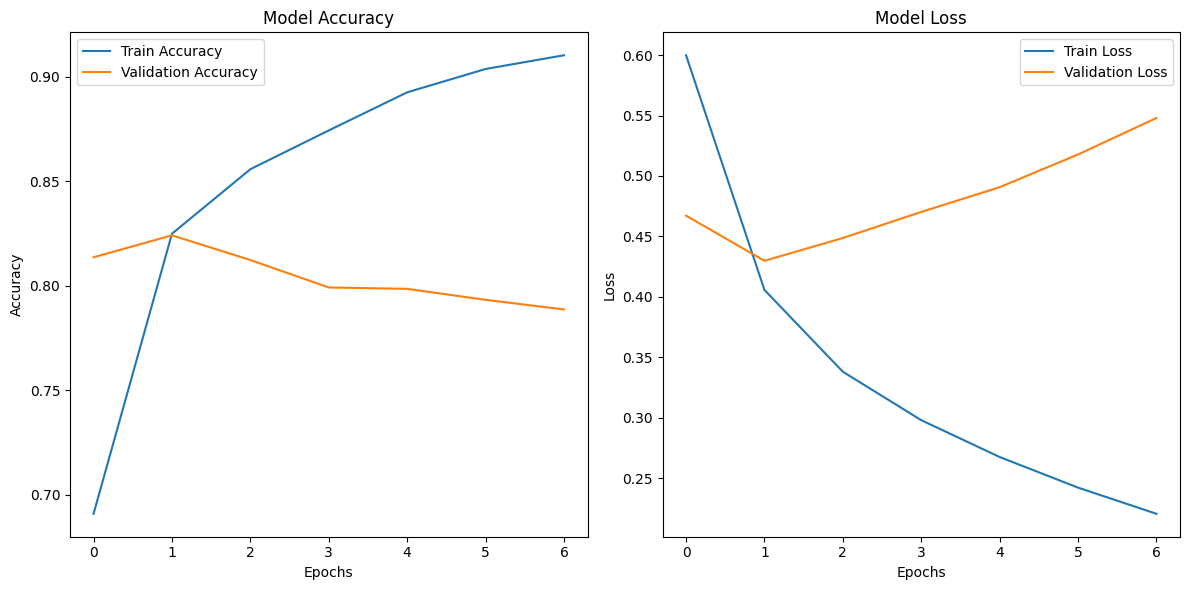

Running models:  17%|█▋        | 5/30 [00:20<01:37,  3.88s/it]

Model: sequential_107, Accuracy: 0.8240, F1 Score: 0.7838
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step - accuracy: 0.7877 - f1_score: 0.7433 - loss: 0.4885


Running models:  20%|██        | 6/30 [00:27<01:55,  4.83s/it]

Model: sequential_108, Accuracy: 0.8076, F1 Score: 0.7686
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - accuracy: 0.7796 - f1_score: 0.7321 - loss: 0.4924


Running models:  23%|██▎       | 7/30 [00:30<01:36,  4.18s/it]

Model: sequential_109, Accuracy: 0.8030, F1 Score: 0.7583
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - accuracy: 0.6306 - f1_score: 0.4525 - loss: 0.6560


Running models:  27%|██▋       | 8/30 [00:38<02:00,  5.48s/it]

Model: sequential_110, Accuracy: 0.6356, F1 Score: 0.4577
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step - accuracy: 0.7940 - f1_score: 0.7349 - loss: 0.4721


Running models:  30%|███       | 9/30 [00:41<01:37,  4.62s/it]

Model: sequential_111, Accuracy: 0.8122, F1 Score: 0.7591
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step - accuracy: 0.7749 - f1_score: 0.7090 - loss: 0.5026


Running models:  33%|███▎      | 10/30 [00:44<01:21,  4.09s/it]

Model: sequential_112, Accuracy: 0.7958, F1 Score: 0.7404
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step - accuracy: 0.7976 - f1_score: 0.7492 - loss: 0.4728


Running models:  37%|███▋      | 11/30 [00:47<01:14,  3.92s/it]

Model: sequential_113, Accuracy: 0.8135, F1 Score: 0.7726
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7867 - f1_score: 0.7253 - loss: 0.4838


Running models:  40%|████      | 12/30 [00:53<01:19,  4.43s/it]

Model: sequential_114, Accuracy: 0.8089, F1 Score: 0.7561
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step - accuracy: 0.7816 - f1_score: 0.7287 - loss: 0.4828


Running models:  43%|████▎     | 13/30 [00:56<01:07,  3.98s/it]

Model: sequential_115, Accuracy: 0.8050, F1 Score: 0.7564
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step - accuracy: 0.5660 - f1_score: 0.0000e+00 - loss: 0.6771


Running models:  47%|████▋     | 14/30 [01:00<01:06,  4.15s/it]

Model: sequential_116, Accuracy: 0.5706, F1 Score: 0.0000
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step - accuracy: 0.7866 - f1_score: 0.7361 - loss: 0.4657


Running models:  50%|█████     | 15/30 [01:03<00:56,  3.78s/it]

Model: sequential_117, Accuracy: 0.8063, F1 Score: 0.7620
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step - accuracy: 0.7739 - f1_score: 0.7078 - loss: 0.4903


Running models:  53%|█████▎    | 16/30 [01:06<00:49,  3.53s/it]

Model: sequential_118, Accuracy: 0.7971, F1 Score: 0.7410
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step - accuracy: 0.7879 - f1_score: 0.7308 - loss: 0.4885


Running models:  57%|█████▋    | 17/30 [01:11<00:48,  3.75s/it]

Model: sequential_119, Accuracy: 0.8135, F1 Score: 0.7633
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7934 - f1_score: 0.7315 - loss: 0.4839


Running models:  60%|██████    | 18/30 [01:17<00:54,  4.55s/it]

Model: sequential_120, Accuracy: 0.8155, F1 Score: 0.7608
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7876 - f1_score: 0.7226 - loss: 0.4856


Running models:  63%|██████▎   | 19/30 [01:23<00:56,  5.13s/it]

Model: sequential_121, Accuracy: 0.8076, F1 Score: 0.7495
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step - accuracy: 0.5660 - f1_score: 0.0000e+00 - loss: 0.6730


Running models:  67%|██████▋   | 20/30 [01:33<01:05,  6.55s/it]

Model: sequential_122, Accuracy: 0.5706, F1 Score: 0.0000
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7938 - f1_score: 0.7430 - loss: 0.4747


Running models:  70%|███████   | 21/30 [01:39<00:56,  6.28s/it]

Model: sequential_123, Accuracy: 0.8096, F1 Score: 0.7615
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step - accuracy: 0.7676 - f1_score: 0.6949 - loss: 0.5000


Running models:  73%|███████▎  | 22/30 [01:44<00:46,  5.81s/it]

Model: sequential_124, Accuracy: 0.7886, F1 Score: 0.7281
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7855 - f1_score: 0.7028 - loss: 0.4941


Running models:  77%|███████▋  | 23/30 [01:54<00:49,  7.10s/it]

Model: sequential_125, Accuracy: 0.8043, F1 Score: 0.7318
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7856 - f1_score: 0.7140 - loss: 0.4755


Running models:  80%|████████  | 24/30 [02:12<01:03, 10.52s/it]

Model: sequential_126, Accuracy: 0.8142, F1 Score: 0.7544
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step - accuracy: 0.7804 - f1_score: 0.7194 - loss: 0.4872


Running models:  83%|████████▎ | 25/30 [02:16<00:42,  8.59s/it]

Model: sequential_127, Accuracy: 0.8037, F1 Score: 0.7482
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 654us/step - accuracy: 0.5660 - f1_score: 0.0000e+00 - loss: 0.6780


Running models:  87%|████████▋ | 26/30 [02:21<00:29,  7.36s/it]

Model: sequential_128, Accuracy: 0.5706, F1 Score: 0.0000
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - accuracy: 0.7940 - f1_score: 0.7322 - loss: 0.4717


Running models:  90%|█████████ | 27/30 [02:25<00:18,  6.30s/it]

Model: sequential_129, Accuracy: 0.8096, F1 Score: 0.7553
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step - accuracy: 0.7680 - f1_score: 0.6949 - loss: 0.4942


Running models:  93%|█████████▎| 28/30 [02:28<00:11,  5.51s/it]

Model: sequential_130, Accuracy: 0.7879, F1 Score: 0.7241
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7889 - f1_score: 0.7386 - loss: 0.4871


Running models:  97%|█████████▋| 29/30 [02:35<00:05,  5.85s/it]

Model: sequential_131, Accuracy: 0.8168, F1 Score: 0.7710
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7881 - f1_score: 0.7308 - loss: 0.4808


Running models: 100%|██████████| 30/30 [02:48<00:00,  5.61s/it]

Model: sequential_132, Accuracy: 0.8089, F1 Score: 0.7588
CPU times: user 7min 16s, sys: 1min 27s, total: 8min 43s
Wall time: 2min 48s


In [249]:
%%time
model_options = [1, 2, 3, 4, 5]
feature_col_options = ['TF-IDF', 'Word2Vec', 'TF-IDF_alot', 'TF-IDF_alot_500', 'TF-IDF_alot_2500', 'TF-IDF_alot_5000']

combinations = [(model, feature_col) for model in model_options for feature_col in feature_col_options]

for model_version, feature_col in tqdm(combinations, desc="Running models"):
    run_full_pipeline(train_df, feature_col, version=model_version)

In [250]:
display(results_df.sort_values(by='f1_score', ascending=False))

,model,accuracy,f1_score,feature_col
4,1,0.824032,0.783785,TF-IDF_alot_2500
10,2,0.813526,0.772634,TF-IDF_alot_2500
28,5,0.816809,0.770983,TF-IDF_alot_2500
5,1,0.807617,0.768632,TF-IDF_alot_5000
2,1,0.814183,0.764603,TF-IDF_alot
16,3,0.813526,0.763274,TF-IDF_alot_2500
14,3,0.806303,0.761990,TF-IDF_alot
20,4,0.809586,0.761529,TF-IDF_alot
17,3,0.815496,0.760765,TF-IDF_alot_5000
8,2,0.812213,0.759095,TF-IDF_alot


In [ ]:
best_model_version = results_df.sort_values(by='f1_score', ascending=False).iloc[0]['model']
best_feature_col = results_df.sort_values(by='f1_score', ascending=False).iloc[0]['feature_col']

print(f"Best model version: {best_model_version}, Best feature column: {best_feature_col}")

submission_df = pd.read_csv('sample_submission.csv')

test_data = test_tfidf_alot_2500_df 

model = run_full_pipeline(train_df, best_feature_col, version=int(best_model_version))

predictions = model.predict(test_data)
submission_df['target'] = (predictions > 0.5).astype(int)
submission_df.to_csv('submission.csv', index=False)

Best model version: 1, Best feature column: TF-IDF_alot_2500
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step - accuracy: 0.7902 - f1_score: 0.7507 - loss: 0.4807
Model: sequential_133, Accuracy: 0.8102, F1 Score: 0.7753
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 640us/step


# Results and Analysis  
Word2Vec was not useful to cath the information about the text.  
TF-IDF demonstrated relatively good performance. The best value was with number of feature = 2500, however, the difference is not big, and this is imperic parameter.  
I tried several models with different number of layers and number of neurons in each layer.  
Suprisingly, reults were combiantion of both - number of features in TF-IDF and architercture of the neural net.  
Another suprise for me was that actually the smallest NN with only one layer provided the best results in the end.  

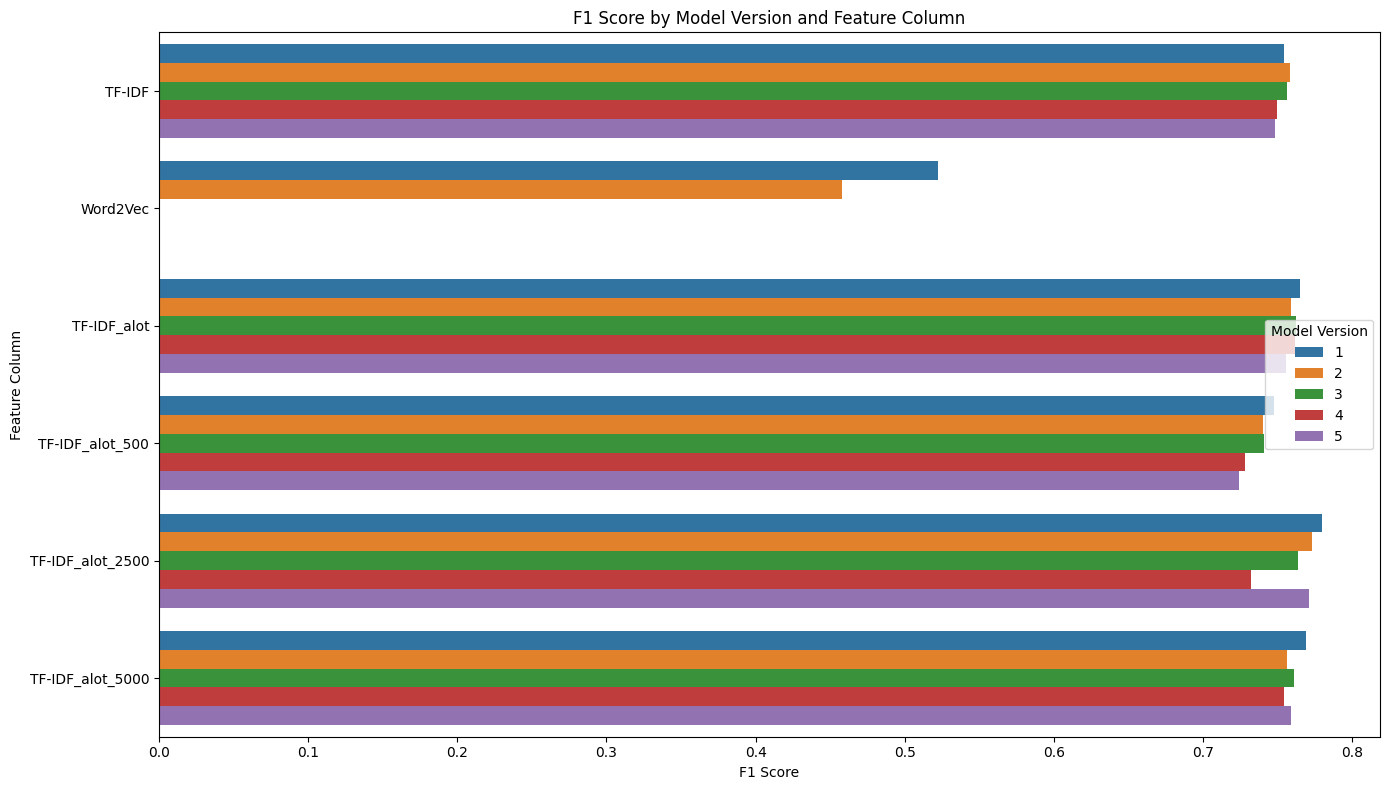

In [255]:
plt.figure(figsize=(14, 8))
sns.barplot(x='f1_score', y='feature_col', hue='model', data=results_df, ci=None)
plt.title('F1 Score by Model Version and Feature Column')
plt.xlabel('F1 Score')
plt.ylabel('Feature Column')
plt.legend(title='Model Version')
plt.tight_layout()
plt.show()

# Conclusion
For me still the key takeway is that optimization of architecture of NN is experement, not a predseign solution.  
The model performed reasonably, however, the score on Kaggle is relatevly low.  
The reason for it and the point to improve is to actually use a more complicated model for text analysis a pretrained one, for example BERT.  
However, in this case it was really interesting to experement on the structure.  
The main result is that, actually, it is better to take a pretrrained neural net...  


### References  
Addison Howard, devrishi, Phil Culliton, and Yufeng Guo. Natural Language Processing with Disaster Tweets. https://kaggle.com/competitions/nlp-getting-started, 2019. Kaggle.  
KerasNLP starter notebook Disaster Tweets - https://www.kaggle.com/code/alexia/kerasnlp-starter-notebook-disaster-tweets  
